# Exploratory Data Analysis, plotting receiver operating characteristic curves for varying discriminant thresholds of different classifiers on a task.

## Setup
### For thhe pipeline to function you must set up a conda environment with a jupyter notebook and prerequisite numpy, pandas and mne libraries imported, current iteration of the pipeline holds the raw .bdf, cleaned .fif and formatted .csv versions of data in separate folders each labelled accordingly with subfolders labeled by subject number. It is important to create these folders ahead of runnning the pipeline preproccessing measure to ensure it operates smoothly. For the raw .bdf files an accompanying set of .evt files are necessary for certain trial 1s of each VPA, VS, and SG task available on Joe's One drive.

#### Step 1: Initialise global variables

##### In order to streamline the pipeline there are several data variables as well as libraries that we will work with over multiple instances, therefore, it is best to isolate them and declare them globally at the start of the file for ease of access. This will prevent us from needing to declare the variables again late ron in the code however changes made here will require the code box to be ran again to ensure the changes get assed down the pipeline.

In [74]:
# Authors: Jack E. Kilgallen, Michelle Collins, Cormac J. Daly, Bogdan Dumitru, Sheriff Timilehin Oyadina

# Importing necessary libraries and models
import mne
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.svm import SVC
from sklearn import metrics
from sklearn import preprocessing
from sklearn import linear_model

from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris

from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import LeavePOut
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold
from sklearn.decomposition import PCA

from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

# Setting the logging level
mne.set_log_level('CRITICAL')

raw_folder_loc = r"C:/Users/User/OneDrive - Maynooth University/EEG Data 2021/Raw EEG BDF files/"

cleaned_folder_loc = r"C:/Users/User/OneDrive - Maynooth University/Personal EEG support folder/CLEANED_folder/"

csv_folder_loc = r"C:/Users/User/OneDrive - Maynooth University/Personal EEG support folder/CSV_Data"


# Select which subjects, trials and tasks you wish to process. Can be changed accordingly depending on which cognitive tests
subjects = ["12","13","14","15","16","17","18","19","20","24","25","26","28","29","30","31","32","33","34","52","53","54","55","56","57","59","60","61"]

trials = ["1","2"]

tasks = ["VPA"]

print(raw_folder_loc)

C:/Users/User/OneDrive - Maynooth University/EEG Data 2021/Raw EEG BDF files/


#### Step 2: Renaming
##### The first step towards handling the data is renaming it to ensure anonimity of the patients and the removal of bias, here this python script written by Michelle Collins takes in the original raw data files and relabels them removing the name and adding in a designated number and only keeping the experiment type, further development of this code is difficult as naming convention plays a large role in how the data is processed, errors will occur when ran and manual renaming will have to occur for those cases however this code helps speed up the overall process instead of needing to rename every singe file manually.

In [75]:
# Main function
def rename_raw_data():

    # Nested for loop used to iterate withing the subject folder of the raw folder
    for folder in os.listdir(raw_folder_loc):
        for file in os.listdir(raw_folder_loc + folder):
            
            # Identify the subject from the folder name (the patient number)
            subject = folder
            
            # Check if the file has already been renamed and if so proceed
            if "_1_VS".lower() in file.lower() or \
            "_1_VPA".lower() in file.lower() or \
            "_2_VS".lower() in file.lower() or \
            "_2_VPA".lower() in file.lower():
                print("File " + file + " already exists")
                continue
            if ".bdf".lower() not in file.lower():
                continue
            
            # Depending on whether or not the string "Exp2b" is in the original name, 
            # determines whether the task will be labeled as the first or second trial
            if "Exp2b".lower() in file.lower():
                trial = "2"
            else:
                trial = "1"
                
            # Identify which task we are relabelling and set the task var accordingly
            if " VPA".lower() in file.lower():
                task = "VPA"
            elif "Visual Search".lower() in file.lower():
                task = "VS"
            elif "finger".lower() in file.lower():
                continue
            elif "eyes".lower() in file.lower():
                continue
            
            # Flag files which may not fall into original naming convention, these will need to be renamed manually
            else:
                print("Did not find task for " + file)
                continue
            
            # Once the file has been correctly identifed the filepath is renamed accordingly and replaces the original
            old_filename = os.path.join(raw_folder_loc, folder, file)
            new_filename = rf"C:/Users/User/OneDrive - Maynooth University/EEG Data 2021/Raw EEG BDF files/{subject}/{subject}_{trial}_{task}.bdf"
            print("Renaming " + old_filename + " to: " + new_filename )
            os.rename(old_filename, new_filename)
            
# Small indicator for once all the files have been renamed
print("finished renaming")

# Run the renaming function
rename_raw_data()

finished renaming
Did not find task for 11_1_SG.bdf
File 11_1_VPA.bdf already exists
File 11_1_VS.bdf already exists
Did not find task for 11_2_SG.bdf
File 11_2_VPA.bdf already exists
File 11_2_VS.bdf already exists
Did not find task for 12_1_SG.bdf
File 12_1_VPA.bdf already exists
File 12_1_VS.bdf already exists
Did not find task for 12_2_SG.bdf
File 12_2_VPA.bdf already exists
File 12_2_VS.bdf already exists
Did not find task for 13_1_SG.bdf
File 13_1_VPA.bdf already exists
File 13_1_VS.bdf already exists
Did not find task for 13_2_SG.bdf
File 13_2_VPA.bdf already exists
File 13_2_VS.bdf already exists
Did not find task for 14_1_SG.bdf
File 14_1_VPA.bdf already exists
File 14_1_VS.bdf already exists
Did not find task for 14_2_SG.bdf
File 14_2_VPA.bdf already exists
File 14_2_VS.bdf already exists
Did not find task for 15_1_SG.bdf
File 15_1_VPA.bdf already exists
File 15_1_VS.bdf already exists
Did not find task for 15_2_SG.bdf
File 15_2_VPA.bdf already exists
File 15_2_VS.bdf already

#### Step 3: Preprocessing
##### The next step is to preprocess the data, there are parts of the raw input that need filtering out, such as eye movement, and this next segment of code handles that. We first set the meta data, in other words the channels we use, then we downsample the data and remove the occular noise.

#### Arguably the most important step in our analysis. Since we are working with such a small dataset it is important we properly remove any contaminent noise which includes ocular, auditory and external power line noise.


In [76]:
# Function to set the meta data used
def set_meta_data(raw):
    # Define the sensor type of channels.
    raw.set_channel_types({'EXG1': 'misc','EXG2':'misc','EXG3':'misc','EXG4':'misc', 'EXG5':'eog','EXG6': 'eog','EXG7':'misc','EXG8':'misc'})
    try:
        # Try to drop these channels but pass if you cannot
        raw.drop_channels(['GSR1', 'GSR2', 'Erg1', 'Erg2', 'Resp', 'Plet', 'Temp'])
    except:
        pass
    
    # Set EEG channel positions and digitization points.
    raw.set_montage('standard_1020')

# Function to downsample the data
def downsample(raw):
    # Find the current frequency and seet the desired one
    current_sfreq = raw.info['sfreq']
    desired_sfreq = 256
    
    # Generate an obtained frequency form the current and desired ones
    decim = np.round(current_sfreq / desired_sfreq).astype(int)
    obtained_sfreq = current_sfreq / decim
    
    # Generate a lowpass frequency from the obtained one
    lowpass_freq = obtained_sfreq / 3.
    
    # Filter a subset of channels using the lowpass frequency
    raw.filter(l_freq=None, h_freq=lowpass_freq)

# Function to remove ocular noise
def remove_ocular_noise(raw):
    
    # This code estimates independent components from raw, epoched, or evoked objects. 
    # Components can optionally be removed i order to repair an artefact before the signal is reconstructed.
    ica = mne.preprocessing.ICA(n_components=0.95, random_state=97)
    
    # Run the decomposition on the raw data
    ica.fit(raw)
    
    # Create a var for excluding components
    ica.exclude = []
    
    # Detect EOG related components using correlation.
    eog_indices, eog_scores = ica.find_bads_eog(raw)
    
    # Exclude those components
    ica.exclude = eog_indices
    
    # Apply the changes to the raw data
    ica.apply(raw)

# Function to preprocess the raw data
def preprocessing(raw):
    
    # Run the previous two functions
    set_meta_data(raw)
    downsample(raw)
    
    # Filter the channels
    raw.filter(l_freq=0.5, h_freq=None)
    
    # Notch filter for the 50Hz frequency
    raw.notch_filter(freqs=[50])
    
    # Try to remove ocular noise
    try:
        remove_ocular_noise(raw)
    except:
        pass
    
    # Return the final preprocessed raw data
    return raw


#### Step 4: Repair event data
##### The next bit of code, handles the repairing of certain task trials of patients which may of ended up corrupt or faulty by one means or another, it is crucial to repair this data as we have very little data to work with in the first place and we want to make sure we can use as much of the data as possible and that the data we use is accurate.

In [77]:
# Function to repair the event data
def repair_event_data(subject, trial, task, raw):
           
    # Read in files.
    file_name = "{}_{}_{}.bdf".format(subject, trial, task)
    file_loc = os.path.join(raw_folder_loc, str(subject), file_name)
    raw = mne.io.read_raw_bdf(file_loc, preload=True)

    # Find and process events.
    event_file_name = "{}_{} {} Corrected Event File.evt".format(trial, subject, task)
    event_file_loc = os.path.join(raw_folder_loc, str(subject), event_file_name)
    events_as_df = pd.read_csv(event_file_loc, delimiter="\t", index_col = False)   
    events_as_df = events_as_df.drop(events_as_df.columns[3], axis=1).drop([1])
    events_as_df = events_as_df[events_as_df['TriNo'] != '-']
    events_as_df['TriNo'] = pd.to_numeric(events_as_df['TriNo'])
    events_as_df['Code'] = events_as_df['Code'].fillna(0)
    events_as_df['Tmu         '] = events_as_df['Tmu         '] / 1953.003030082584
    event_file_name = "{}_{}_{}.eve".format(subject, trial, task)
    event_file_loc = os.path.join(raw_folder_loc, event_file_name)
    np.savetxt(event_file_loc, events_as_df.values, fmt = '%d', delimiter='\t')

    # Repair and clean the raw data
    events = mne.read_events(event_file_loc)
    for x in range(len(events)):
        if events[x][2] > 1 and events[x][2] < 10:
            events[x][2] -= 2
    raw.add_events(events, stim_channel='Status', replace=True)
    repaired_file_name = "{}_{}_{}_(Cleaned).fif".format(subject, trial, task)
    repaired_file_loc = os.path.join(cleaned_folder_loc, str(subject), repaired_file_name)
    raw.save(repaired_file_loc, overwrite=True)
    
    return raw

#### Event data processing
##### The next step in the pipelining process is to handle the event data. What this next segment of code does is it relabels events based on which task you are using and then utilises the rest of the pipeline functions, such as the preprocessing and data renaming, to clean the raw data files.

In [78]:

# Function to relabel VPA events
def relabel_VPA_events(events):
    
    for x in range(len(events) - 1):
        # F/C/C
        if events[x][2] == 4 and events[x+1][2] == 10:
            events[x][2] = 12
        # F/C/I
        elif events[x][2] == 4 and events[x+1][2] == 11:
            events[x][2] = 13
        # F/I/C
        elif events[x][2] == 5 and events[x+1][2] == 10:
            events[x][2] = 14
        # F/I/I
        elif events[x][2] == 5 and events[x+1][2] == 11:
            events[x][2] = 15
        # T/C/C
        elif events[x][2] == 6 and events[x+1][2] == 10:
            events[x][2] = 16
        # T/C/I
        elif events[x][2] == 6 and events[x+1][2] == 11:
            events[x][2] = 17
        # T/I/C
        elif events[x][2] == 7 and events[x+1][2] == 10:
            events[x][2] = 18
        # T/I/I
        elif events[x][2] == 7 and events[x+1][2] == 11:
            events[x][2] = 19

# Function to relabel VS events
def relabel_VS_events(events):
    
    for x in range(len(events) - 1):
        # F LEFT/C
        if events[x][2] == 1 and events[x+1][2] == 10:
            events[x][2] = 12
        # F LEFT/I
        elif events[x][2] == 1 and events[x+1][2] == 11:
            events[x][2] = 13
        # LEFT/C
        elif events[x][2] == 2 and events[x+1][2] == 10:
            events[x][2] = 14
        # LEFT/I
        elif events[x][2] == 2 and events[x+1][2] == 11:
            events[x][2] = 15
        # RIGHT/C
        elif events[x][2] == 3 and events[x+1][2] == 10:
            events[x][2] = 16
        # RIGHT/I
        elif events[x][2] == 3 and events[x+1][2] == 11:
            events[x][2] = 17
        # F RIGHT/C
        elif events[x][2] == 4 and events[x+1][2] == 10:
            events[x][2] = 18
        # F RIGHT/I
        elif events[x][2] == 4 and events[x+1][2] == 11:
            events[x][2] = 19

# Function to relabel SG events
def relabel_SG_events(events):
    
    for x in range(len(events) - 1):
        # NRSL/C
        if events[x][2] == 1 and events[x+1][2] == 10:
            events[x][2] = 12
        # NRSL/I
        elif events[x][2] == 1 and events[x+1][2] == 11:
            events[x][2] = 13
        # RSL/C
        elif events[x][2] == 2 or events[x][2] == 3 or events[x][2] == 4 and events[x+1][2] == 10:
            events[x][2] = 14
        # RSL/I
        elif events[x][2] == 2 or events[x][2] == 3 or events[x][2] == 4 and events[x+1][2] == 11:
            events[x][2] = 15
        # NRNL/C
        elif events[x][2] == 5 and events[x+1][2] == 10:
            events[x][2] = 16
        # NRNL/I
        elif events[x][2] == 5 and events[x+1][2] == 11:
            events[x][2] = 17
        # RNL/C
        elif events[x][2] == 6 or events[x][2] == 7 or events[x][2] == 8 and events[x+1][2] == 10:
            events[x][2] = 18
        # RNL/I
        elif events[x][2] == 6 or events[x][2] == 7 or events[x][2] == 8 and events[x+1][2] == 11:
            events[x][2] = 19

# Function to utilise relabelling functions
def event_data_processing(raw, task):
    
    events = mne.find_events(raw, stim_channel='Status')
    
    if task == "VPA":
        relabel_VPA_events(events)
    elif task == "VS":
        relabel_VS_events(events)
    elif task == "SG":
        relabel_SG_events(events)
        
    raw.add_events(events, stim_channel='Status', replace=True)
    
    return raw

for subject in subjects:
    for trial in trials:
        for task in tasks:
            
            print("Now pipelining subject: " + subject + ", trial: " + trial + ", task: " + task)
            file_name = "{}_{}_{}.bdf".format(subject, trial, task)
            file_loc = os.path.join(raw_folder_loc, subject, file_name)
            
            raw = mne.io.read_raw_bdf(file_loc, preload=True)
            raw = preprocessing(raw)
            
            # Try to repair data
            try:
                raw = repair_event_data(subject, trial, task, raw)
            except FileNotFoundError as e:
                pass
                
            raw = event_data_processing(raw, task)
            file_name_cleaned = "{}_{}_{}_(Cleaned).fif".format(subject, trial, task)
            file_loc = os.path.join(cleaned_folder_loc, subject, file_name_cleaned)
            raw.save(file_loc, overwrite=True)
            print("Cleaned file " + file_name_cleaned + " saved")


Now pipelining subject: 12, trial: 1, task: VPA
Cleaned file 12_1_VPA_(Cleaned).fif saved
Now pipelining subject: 12, trial: 2, task: VPA
Cleaned file 12_2_VPA_(Cleaned).fif saved
Now pipelining subject: 13, trial: 1, task: VPA
Cleaned file 13_1_VPA_(Cleaned).fif saved
Now pipelining subject: 13, trial: 2, task: VPA
Cleaned file 13_2_VPA_(Cleaned).fif saved
Now pipelining subject: 14, trial: 1, task: VPA
Cleaned file 14_1_VPA_(Cleaned).fif saved
Now pipelining subject: 14, trial: 2, task: VPA
Cleaned file 14_2_VPA_(Cleaned).fif saved
Now pipelining subject: 15, trial: 1, task: VPA
Cleaned file 15_1_VPA_(Cleaned).fif saved
Now pipelining subject: 15, trial: 2, task: VPA
Cleaned file 15_2_VPA_(Cleaned).fif saved
Now pipelining subject: 16, trial: 1, task: VPA
Cleaned file 16_1_VPA_(Cleaned).fif saved
Now pipelining subject: 16, trial: 2, task: VPA
Cleaned file 16_2_VPA_(Cleaned).fif saved
Now pipelining subject: 17, trial: 1, task: VPA
Cleaned file 17_1_VPA_(Cleaned).fif saved
Now pipeli

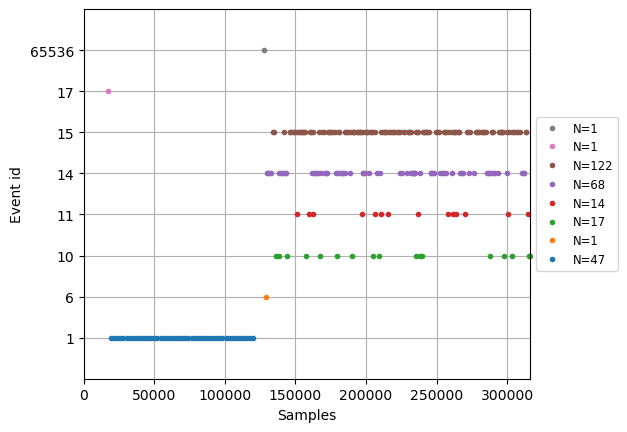

In [79]:
#debugging code to make sure the files have been cleaned correctly
raw_fif = mne.io.read_raw_fif(rf'C:/Users/User/OneDrive - Maynooth University/Personal EEG support folder/CLEANED_folder/12/12_1_VPA_(Cleaned).fif')
events = mne.find_events(raw_fif)
mne.viz.plot_events(events);

#### Generating evoked responses
##### This part of the pipeline uses the newly cleaned data files and process them to generate evoked responses of the patients to the tasks 

In [81]:
# The following variables should contain the location of the EEG files, 
# as well as the subjects, and trials that you wish to get evoked responses for.
subjects = ["12","13","14","15","16","17","18","19","20","24","25","26","28","29","30","31","32","33","34","52","53","54","55","56","57","59","60","61"]
trials = ["1","2"]

# The task for evoked responses to be estimated for, as well as the appropriate window should be provided.
task = "VPA"
window = [0.2, 0.4]

for subject in subjects:
    for trial in trials:
        
        file_name = "{}_{}_{}_(cleaned).fif".format(subject, trial, task)
        file_loc = os.path.join(cleaned_folder_loc, subject, file_name)
        raw = mne.io.read_raw_fif(file_loc, preload=True)
        events = mne.find_events(raw, stim_channel='Status')
        
        # If downsampling frequency is changed decim will need to change also.
        # Decim is the integer result of dividing original frequency by downsampled frequency.
        event_dict = {'false/congruent/correct': 12, 'false/congruent/incorrect': 13,
              'false/incongruent/correct': 14, 'false/incongruent/incorrect': 15,
              'true/congruent/correct': 16, 'true/congruent/incorrect': 17,
              'true/incongruent/correct': 18, 'true/incongruent/incorrect': 19}
        
        epochs = mne.Epochs(raw, events, event_id=event_dict, tmin=window[0], tmax=window[1], baseline = None, preload=True, on_missing='ignore', decim=4)

        # Generate evoked responses for correct vs incorrect events
        for item in ['correct','incorrect']:
            item_epochs = epochs[item]
            evoked_response = item_epochs.average()
            export_name = "{}_{}_{}_{}.csv".format(subject, trial, task, '_'.join(item.split('/')))
            export_loc = os.path.join(csv_folder_loc, str(subject), export_name)
            evoked_response.to_data_frame().to_csv(export_loc)

#### Classification
##### This is the final step of the pipeline, with the data fully preprocessed we can look towards doing some data analysis. In this case we are looking to generate a reciever operating characteristic curve based off of the classsification method(s) we use on the data to determine how accurate the classifer(s) are at predicting whether a subject is part of the control group or a patient, in other words, how good the classifier is at predicting if a subject sustained a stroke.

In [83]:
# The following variables should contain the subjects, trials, and tasks that are to be used in classification.

subjects = ["12","13","14","15","16","17","18","19","20","24","25","26","28","29","30","31","32","33","34","52","53","54","55","56","57","59","60","61"]

trials = ["1","2"]

tasks = ["VPA"]

task_categories = {"VPA": ['correct']}

#Creating a poandas dataframe to use with the classifiers
df = pd.DataFrame(columns=['Subject', 'Trial', 'Task', 'Category', 'Group','time', 
                           'Fp1', 'AF3', 'F7', 'F3', 'FC1', 'FC5', 'T7', 'C3', 'CP1', 'CP5',
                           'P7', 'P3', 'Pz', 'PO3', 'O1', 'Oz', 'O2', 'PO4', 'P4', 'P8', 'CP6',
                           'CP2', 'C4', 'T8', 'FC6', 'FC2', 'F4', 'F8', 'AF4', 'Fp2', 'Fz', 'Cz'])

#setting key values within the dataframe as well as whether the subject is a patient (0) or control (1)
for subject in subjects:
    for trial in trials:
        for task in tasks:
            for category in task_categories[task]:
                file_name = "{}_{}_{}_{}.csv".format(subject, trial, task, category)
                file_loc = os.path.join(csv_folder_loc, subject, file_name)
                tmp = pd.read_csv(file_loc, index_col=0)
                tmp['Subject'] = subject
                tmp['Trial'] = trial 
                tmp['Task'] = task
                tmp['Category'] = category
                if int(subject) <50:
                    tmp['Group'] = 0
                else:
                    tmp['Group'] = 1
                # If downsampling frequency is changed, samples will need to be changed also
                samples = 256
                if len(tmp) > samples - 1:
                    tmp = tmp.truncate(after=samples - 1)
                
                pd.concat([df, tmp])

#Adding a global field power variable for evaluation
df['GFP'] = df.loc[:,'Fp1':'Cz'].mean(axis=1)

#Defining the Leave one out classifier model
def leave_one_out_f1(x, y):
    
    clf = SVC(kernel='linear')
    loo = LeaveOneOut()
    loo.get_n_splits(x)
    y_pred = []

    for train_index, test_index in loo.split(x):
        
        clf.fit(x[train_index], y[train_index])
        y_pred.append(*clf.predict(x[test_index]))
        
        #define metrics for plotting ROC
        fpr, tpr, _ = metrics.roc_curve(y[test_index],  y_pred)

        #create ROC curve
        plt.plot(fpr,tpr)
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.show()

    
    return metrics.f1_score(y, y_pred)

#Defining the Leave one out classifier model
def leave_p_out_f1(x, y):

    clf = SVC(kernel='linear')
    clf= KNeighborsClassifier(n_neighbors=1)
    lpo = LeavePOut(p=2)
    lpo.get_n_splits(x)
    y_pred = []

    for train_index, test_index in lpo.split(x):
        
        clf.fit(x[train_index], y[train_index])
        y_pred=clf.predict(x[test_index])
        
        #define metrics for plotting ROC
        fpr, tpr, _ = metrics.roc_curve(y[test_index],  y_pred)

        #create ROC curve
        plt.plot(fpr,tpr)
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.show()
        
    return metrics.f1_score(y[test_index], y_pred)

#Defining the kFolds classifier model
def Kfold(x, y):
    
    clf = SVC(kernel='linear')
    clf = DecisionTreeClassifier(random_state=1)
    kf = KFold(n_splits=4)
    kf.get_n_splits(x)
    y_pred = []
    
    for train_index, test_index in kf.split(x):
        
        clf.fit(x[train_index], y[train_index])
        y_pred=clf.predict(x[test_index])
        
        #define metrics for plotting ROC
        fpr, tpr, _ = metrics.roc_curve(y[test_index],  y_pred)

        #create ROC curve
        plt.plot(fpr,tpr)
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.show()
        
    return metrics.f1_score(y[test_index], y_pred)

#Defining the RKfolds classifier model
def RKfold(x, y):
    
    clf = SVC(kernel='linear')
    rkf = RepeatedKFold(n_splits=2, n_repeats=2, random_state=2652124)
    y_pred = []

    for train_index, test_index in rkf.split(x):
        
        clf.fit(x[train_index], y[train_index])
        y_pred=clf.predict(x[test_index])
        
        #define metrics for plotting ROC
        fpr, tpr, _ = metrics.roc_curve(y[test_index],  y_pred)

        #create ROC curve
        plt.plot(fpr,tpr)
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.show()
        
    return metrics.f1_score(y[test_index], y_pred)

#Labelling patients as 0 and controls as 1
x = []
y = []

for subject in subjects:
    
    tmp = df[df['Subject'] == subject]['GFP']
    x.append(tmp)
    y.append(0 if int(subject) < 50 else 1)
x = np.array(x)
y = np.array(y)

print('GFP:', leave_one_out_f1(x,y))

channels = ['Fp1', 'AF3', 'F7', 'F3', 'FC1', 'FC5', 'T7', 'C3', 'CP1', 'CP5',
            'P7', 'P3', 'Pz', 'PO3', 'O1', 'Oz', 'O2', 'PO4', 'P4', 'P8', 'CP6',
            'CP2', 'C4', 'T8', 'FC6', 'FC2', 'F4', 'F8', 'AF4', 'Fp2', 'Fz', 'Cz']

for channel in channels:
    
    x = []
    
    for subject in subjects:
        
        tmp = df[df['Subject'] == subject][channel]
        x.append(tmp)
        
    x = np.array(x)
    min_max_scaler = MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    x = np.array(x_scaled)
    x = [item for subject in x for item in subject]
    df[channel] = x


scores = []

for channel in channels:
    
    x = []
    y = []
    
    for subject in subjects:
        tmp = df[df['Subject'] == subject][channel]
        x.append(tmp)
        y.append(0 if int(subject) < 23 else 1)
    x = np.array(x)
    y = np.array(y)

    f1 = leave_one_out_f1(x,y)
    print(channel, f1)

ValueError: Found array with 0 feature(s) (shape=(27, 0)) while a minimum of 1 is required by SVC.

In [48]:
import pandas as pd
from sklearn.svm import SVC
from sklearn.model_selection import LeaveOneOut
from sklearn import metrics
from sklearn import preprocessing
import numpy as np
import os

# The following variables should contain the location of the EEG files, 
# as well as the subjects, trials, and tasks that are to be used in classification.
folder_loc = "C:/Users/User/Documents/FYP personal/CSV_Data/"
subjects = ["12","13","14","15","16","17","18","19","20","21","22","24","25","26","28","29","30","31","32","33","34","52","53","54","55","56","57","59","60","61"]
trials = ["1","2"]
tasks = ["VPA"]
task_categories = {"VPA": ["correct", "incorrect", 
              "correct", "incorrect"]}

df = pd.DataFrame(columns=['Subject', 'Trial', 'Task', 'Category', 'Group','time', 
                           'Fp1', 'AF3', 'F7', 'F3', 'FC1', 'FC5', 'T7', 'C3', 'CP1', 'CP5',
                           'P7', 'P3', 'Pz', 'PO3', 'O1', 'Oz', 'O2', 'PO4', 'P4', 'P8', 'CP6',
                           'CP2', 'C4', 'T8', 'FC6', 'FC2', 'F4', 'F8', 'AF4', 'Fp2', 'Fz', 'Cz'])

def leave_one_out_f1(x, y):
    clf = SVC(kernel='linear')
    loo = LeaveOneOut()
    loo.get_n_splits(x)
    y_pred = []
    for train_index, test_index in loo.split(x):
        x_train, x_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]
        clf.fit(x_train, y_train)
        y_pred.extend(clf.predict(x_test))
    return metrics.f1_score(y, y_pred, average='macro')

for subject in subjects:
    for trial in trials:
        for task in tasks:
            for category in task_categories[task]:
                file_name = "{}_{}_{}_{}.csv".format(subject, trial, task, category)
                file_loc = os.path.join(folder_loc, subject, file_name)
                tmp = pd.read_csv(file_loc, index_col=0)
                tmp['Subject'] = subject
                tmp['Trial'] = trial 
                tmp['Task'] = task
                tmp['Category'] = category
                if int(subject) <50:
                    tmp['Group'] = 0
                else:
                    tmp['Group'] = 1
                # If downsampling frequency is changed, samples will need to be changed also
                samples = 256
                if len(tmp) > samples - 1:
                    tmp = tmp.truncate(after=samples - 1)
                df = df.append(tmp, ignore_index=True)

df['GFP'] = df.loc[:,'Fp1':'Cz'].mean(axis=1)

# Now, let's set up the data for classification with leave-one-out cross-validation
x = df[['GFP']].to_numpy()  # We convert the DataFrame to a NumPy array for scikit-learn compatibility
y = df['Group'].to_numpy()

print('GFP:', leave_one_out_f1(x, y))

# Apply MinMaxScaler to the feature columns
scaler = preprocessing.MinMaxScaler()
df.loc[:, 'Fp1':'Cz'] = scaler.fit_transform(df.loc[:, 'Fp1':'Cz'])

# Calculate the F1 score for each channel
f1_scores = {}
for channel in df.columns[df.columns.get_loc('Fp1'):df.columns.get_loc('Cz')+1]:
    x_channel = df[[channel]].to_numpy()
    f1_scores[channel] = leave_one_out_f1(x_channel, y)

# Print the F1 score for each channel
for channel, f1_score in f1_scores.items():
    print(f'{channel}: {f1_score}')


AttributeError: 'DataFrame' object has no attribute 'append'